# Model CNN do wykrywania, czy oczy kierowcy są otwarte czy zamknięte

Cel: Stworzenie modelu będącego częścią projektu wykrywania zmęczenia u kierowców na podstawie czasu przez jaki kierowca ma zamknięte oczy. Model ma na celu ocenić stan oka - otwarte lub zamknięte.

## 1. Import bibliotek oraz danych

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from keras.src.legacy.preprocessing.image import ImageDataGenerator

Etykiety zdjęć są przypisywane na podstawie folderu, w którym dane zdjęcie się znajduje: 'open' lub 'closed':

In [3]:
labels = os.listdir("../data/photos")

In [4]:
labels

['closed', 'open']

Przykładowe zdjęcie i jego rozmiary:

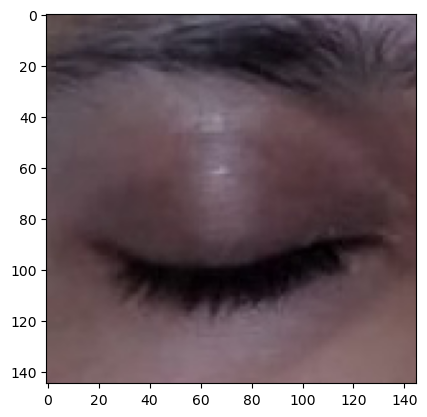

In [8]:
plt.imshow(plt.imread("../data/photos/closed/_0.jpg"))

In [ ]:
a = plt.imread("../data/photos/closed/_0.jpg")

In [ ]:
a.shape

Funkcja 'get_data' służy do wczytywania obrazów z określonego katalogu, a następnie przetwarzania ich do postaci, która może być wykorzystana do trenowania modeli. Obrazy są skalowane do rozmiaru 145. 

In [9]:
def get_data(dir_path="../data/photos/"):
    labels = ['closed', 'open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        print(class_num)
        print(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [10]:
data_train = get_data()

0
closed
1
open


## 2. Przygotowanie i augmentacja danych do trenowania modelu

Tworzone są dwie listy 'X' dla przechowywania obrazów i 'y' dla etykiet. Wypełniane są iteracyjnie przez 'data_train':

In [11]:
X = []
y = []
for feature, label in data_train:
    X.append(feature)
    y.append(label)

Następnie 'X' i 'y' są konwertowane na tablice numpy, a 'X' dodatkowo jest przekształcane do wymiarów odpowiadających formatowi wymaganemu przez modele CNN:

In [12]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

Normalizacja danych: przekształcenie zakresu wartości 'X' z 0-255 na 0-1.

In [13]:
X = X / 255.0

In [14]:
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [15]:
y = np.array(y)

Dane są dzielone na zbiory trenujące i testujące, gdzie 30% danych jest wykorzystywane jako zbiór testowy. Ustawienie 'stratify=y' ma gwarantować, że oba zbiory będą miały podobne proporcje klas.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

Etykiety są przekształcane do formatu kategorialnego, co jest wymagane do później użytej funkcji straty 'binary-crossentropy'.

In [17]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

Zastosowanie augmentacji danych ma pomóc w zwiększeniu różnorodności danych poprzez losowe modyfikacje obrazów (zmiana skali, lustrzane odbicie, rotacja), natomiast tworzenie generatorów danych umożliwia efektywniejsze ładowanie i przetwarzanie danych podczas trenowania modelu.

In [18]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

## 3. Trenowanie modeli i ocena ich skuteczności

### Model 1

Ten model to prosta konwolucyjna sieć neuronowa, która zawiera dwie warstwy konwolucyjne z filtrami 32 i 64 oraz funkcją aktywacji ReLU, połączone z wartstwami MaxPooling. Warstwa Flatten przekształca dane do wektora, który jest przetwarzany przez gęstą warstwę z 128 neuronami i dropoutem 0.5, w celu zmniejszenia ryzyka przeuczenia. Ostatnia warstwa Dense z dwoma wyjściami i funkcją aktywacji softmax służy do klasyfikacji obrazów na dwie klasy.

In [72]:
input_shape = (145, 145, 3)
num_classes = 2

model_1 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 143, 143, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 69, 69, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 73984)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       9,470,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,489,730 (36.20 MB)

 Trainable params: 9,489,730 (36.20 MB)

 Non-trainable params: 0 (0.00 B)

Proces trenowania tego modelu polega na przetworzeniu całego zestawu danych treningowych przez model 50 razy, dane te są podzielone na mniejsze grupy 'batch', gdzie każdy 'batch' zawiera 32 przykłady. Do walidacji po każdym 'epoch' wykorzystywane są dane testowe, co pozwala na monitorowanie i ocenę wydajności modelu.

In [73]:
history_1 = model_1.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.6161 - loss: 0.7964 - val_accuracy: 0.8968 - val_loss: 0.2821
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - accuracy: 0.9114 - loss: 0.2584 - val_accuracy: 0.9472 - val_loss: 0.1755
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - accuracy: 0.9396 - loss: 0.1763 - val_accuracy: 0.9220 - val_loss: 0.1595
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.9516 - loss: 0.1239 - val_accuracy: 0.9381 - val_loss: 0.1443
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.9704 - loss: 0.0952 - val_accuracy: 0.9518 - val_loss: 0.1336
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.9748 - loss: 0.0913 - val_accuracy: 0.9610 - val_loss: 0.1120
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.9824 - loss: 0.0666 - val_accuracy: 0.9679 - val_loss: 0.1163
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.9825 - loss: 0.0679 - val_accuracy: 0.

**Wykresy dokładności i straty**

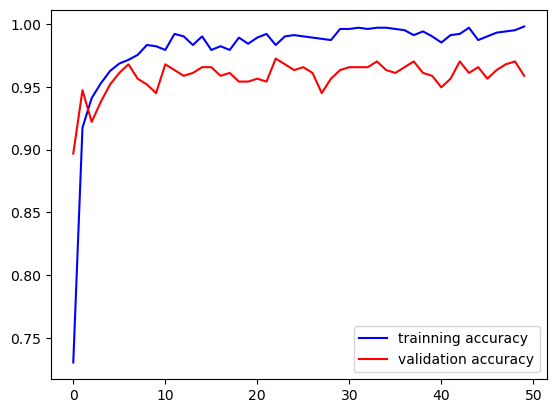

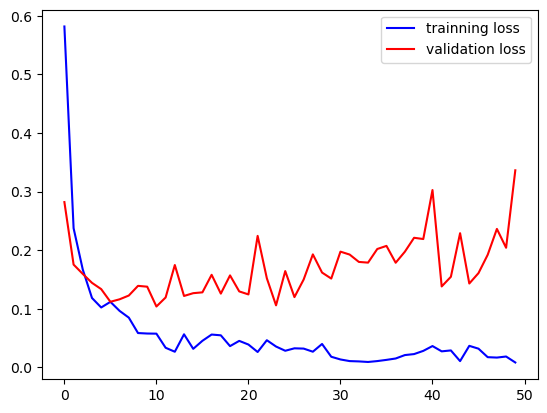

In [74]:
accuracy = history_1.history['accuracy']
val_accuracy = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

Dokładność trenowania osiąga poziom bliski 100%, natomiast dokładność walidacyjna ma poziom około 95%, co jest dobrym wynikiem, lecz może sugerować, że model może być lekko przeuczony. Strata trenowania sukcesywnie maleje, osiągając niski poziom, natomiast strata walidacyjna delikatnie oscyluje wokół wartości około 0.2.

**Raport klasyfikacji i funkcje pomocnicze**

In [28]:
def prepare_image(filepath, IMG_SIZE=145):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255.0

In [30]:
def predict_state(filepath, model):
    prepared_image = prepare_image(filepath)
    prediction = model.predict(prepared_image)
    return prediction[0][0] 

In [42]:
predictions = model_1.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


In [43]:
report = classification_report(true_classes, predicted_classes, target_names=['open', 'closed'])
print(report)

              precision    recall  f1-score   support

        open       0.93      0.99      0.96       218
      closed       0.99      0.93      0.96       218

    accuracy                           0.96       436
   macro avg       0.96      0.96      0.96       436
weighted avg       0.96      0.96      0.96       436


Precision (Precyzja) to stosunek poprawnie przewidzianych pozytywnych obserwacji do ogólnej liczby przewidzianych jako pozytywne. W przypadku tego modelu 93% przypadków, które model przewidział jako oczy otwarte były rzeczywiście otwarte, a 99% przypadków uznanych za oczy zamknięte, rzeczywiście było zamkniętych.
Recall (Odwzorowanie) to stosunek poprawnie przewidzianych pozytywnych obserwacji do ogólnej liczby rzeczywistych pozytywów. W tym przypadku model poprawne zidentyfikował 99% wszystkich rzeczywistych przypadków otwartych oczu, a 93% wszystkich rzeczywistych przypadków zamkniętych oczu.

### Model 2

Ten model zawiera cztery warstwy konwolucyjne z rosnącą liczbą filtrów (32, 64, 128, 128), każda z nich następuje po operacji MaxPooling, która pomaga w redukcji wymiarowości przy zachowaniu istitnych cech. Warstwy gęste z 512 jednostkami i Dropoutem (0.5) minimalizują ryzyko przeuczenia, a softmax klasyfikuje obrazy na dwie klasy.

In [19]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(145, 145, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.summary()


C:\Users\sonia\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 143, 143, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 71, 71, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 69, 69, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,634 (13.17 MB)

 Trainable params: 3,453,634 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Proces i parametry trenowania tego modelu są takie same jak w przypadku poprzedniego.

In [20]:
history_2 = model_2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 499ms/step - accuracy: 0.6353 - loss: 0.6478 - val_accuracy: 0.9266 - val_loss: 0.2499
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - accuracy: 0.9092 - loss: 0.2387 - val_accuracy: 0.9495 - val_loss: 0.1578
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 481ms/step - accuracy: 0.9548 - loss: 0.1309 - val_accuracy: 0.9518 - val_loss: 0.1484
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - accuracy: 0.9674 - loss: 0.0987 - val_accuracy: 0.9427 - val_loss: 0.2734
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 473ms/step - accuracy: 0.9693 - loss: 0.1116 - val_accuracy: 0.9587 - val_loss: 0.1536
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - accuracy: 0.9746 - loss: 0.0637 - val_accuracy: 0.9404 - val_loss: 0.1951
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - accuracy: 0.9765 - loss: 0.0810 - val_accuracy: 0.9587 - val_loss: 0.1143
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 474ms/step - accuracy: 0.9803 - loss: 0.0480 - val_accu

**Wykresy dokładności i straty**

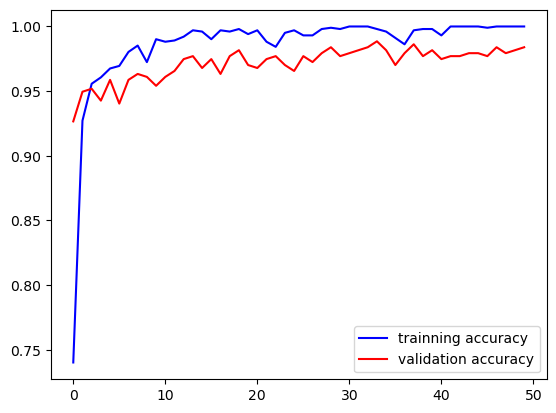

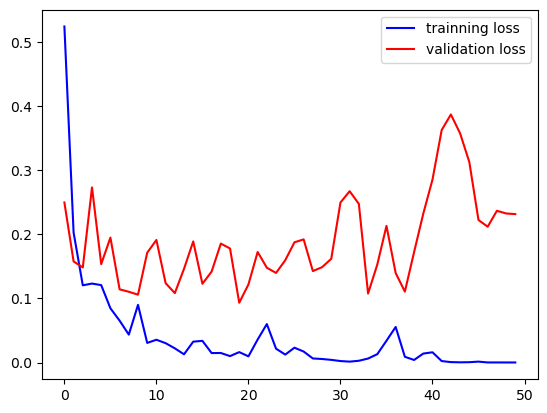

In [21]:
accuracy = history_2.history['accuracy']
val_accuracy = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

Dokładność trenowania po szybkim wzroście osiąga wartości bliskie 100%, co sugeruje bardzo skuteczne rozpoznawanie cech danych uczących przez model. Dokładność walidacyjna stabilizuje się powyżej 95%. Strata trenowania utrzymuje niski poziom przez cały proces uczenia, zatem model skutecznie minimalizuje błędy na danych uczących. Strata walidacyjna jest bardziej zmienna, co może sugerować, że w danych mogą występować trudniejsze do nauczenia cechy.

**Raport klasyfikacji**

In [23]:
predictions = model_2.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


In [24]:
report = classification_report(true_classes, predicted_classes, target_names=['open', 'closed'])
print(report)

              precision    recall  f1-score   support

        open       0.98      0.99      0.98       218
      closed       0.99      0.98      0.98       218

    accuracy                           0.98       436
   macro avg       0.98      0.98      0.98       436
weighted avg       0.98      0.98      0.98       436


Precyzja wynosi 98% z odwzorowaniem 99% dla klasy 'open', co oznacza prawie doskonałą identyfikację otwartych oczu z minimalną ilością fałszywych pozytywów. Dla klasy 'closed' Precyzja wynosi 99% z odwzorowaniem 98%, więc prawie wszystkie przewidziane jako zamknięte oczy faktycznie były zamknięte, chociaż 2% rzeczywistych zamkniętych oczu nie zostało wykrytych.

### Model 3

Ostatni model skłąda się z czterech warstw konwolucyjnych z użyciem Batch Normalization po każdej warstwie konwolucyjnej i przed MaxPooling, co pomaga w normalizacji aktywacji i przyspiesza trening. Struktura warstw gęstych i Dropoutu jest podobna do modelu 2, ale z dodatkową Batch Normalization przed ostatnią warstwą Dense.

In [55]:
model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(145, 145, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

advanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
advanced_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 145, 145, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 145, 145, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 36, 36, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │      10,617,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,010,754 (42.00 MB)

 Trainable params: 11,008,770 (42.00 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [56]:
history_3 = model_3.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8534 - loss: 0.4466 - val_accuracy: 0.5000 - val_loss: 2.3068
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 976ms/step - accuracy: 0.9587 - loss: 0.1305 - val_accuracy: 0.5000 - val_loss: 2.0418
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 997ms/step - accuracy: 0.9769 - loss: 0.0818 - val_accuracy: 0.5000 - val_loss: 2.2575
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9822 - loss: 0.0615 - val_accuracy: 0.5000 - val_loss: 2.6884
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 990ms/step - accuracy: 0.9848 - loss: 0.0568 - val_accuracy: 0.5000 - val_loss: 1.9842
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 982ms/step - accuracy: 0.9843 - loss: 0.0354 - val_accuracy: 0.5023 - val_loss: 1.2572
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 979ms/step - accuracy: 0.9716 - loss: 0.0714 - val_accuracy: 0.5482 - val_loss: 1.1905
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 970ms/step - accuracy: 0.9795 - loss: 0.0494 - val_accuracy: 

**Wykresy dokładności i straty**

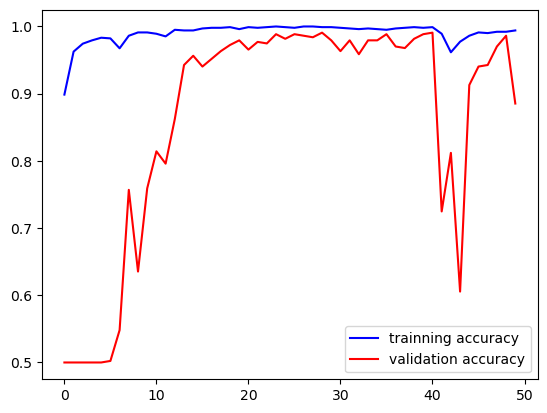

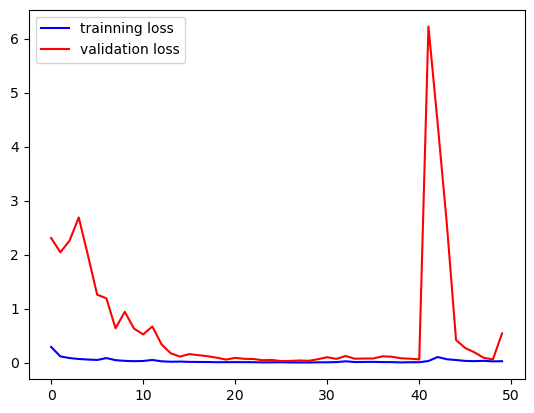

In [63]:
accuracy = history_3.history['accuracy']
val_accuracy = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

Dokładność trenowania ma poziom około 100%, natomiast dokładność walidacyjna pokazuj większe wahania, zwłaszcza około 40 epoki, gdzie widoczny jest gwałtowny spadek, może to być oznaka przeuczenia lub problemó z niestabilnością danych walidacyjnych. Strata trenowanie utrzymuje bardzo niski poziom około 0, natomiast strata walidacyjna podobnie jak dokładność wykazuję gwałtowny skok pomiędzy 40 a 50 epoką, co może wskazywać na nieodpowiednie dopasowanie modelu do złożoności danych walidacyjnych. 

**Raport klasyfikacji**

In [64]:
predictions = model_3.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step


In [65]:
report = classification_report(true_classes, predicted_classes, target_names=['open', 'closed'])
print(report)

              precision    recall  f1-score   support

        open       0.82      0.99      0.90       218
      closed       0.99      0.78      0.87       218

    accuracy                           0.89       436
   macro avg       0.90      0.89      0.88       436
weighted avg       0.90      0.89      0.88       436


Dla klasy 'open' precyzja wynosi 82%, a odwzorowanie 99%, więc model jest skuteczny w rozpoznawaniu otwartych oczu, ale często błędnie je klasyfikuje. Dla klasy 'closed' precyzja jest na poziomie 99% przy odwzorowaniu 78%, co oznacza, że prawie wszystkie przewidziane przypadki zamkniętych oczu są prawidłowe, ale model nie jest w stanie zidentyfikować wszystkich rzeczywistych przypadków zamkniętych oczu.

## 4. Podsumowanie

Najlepsze wyniki zarówno dla trenowania, jak i walidacji wykazuje model 2. Skuteczność modelu w klasyfikacji otwartych i zamknietych oczu jest dokładna, z bardzo wysoką precyzją i odwzorowaniem. 

In [25]:
model_2.save("model_2.h5")